In [1]:
import hashlib
import os
import tarfile
import zipfile
import requests

%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l
from torch.utils import data

from collections import Counter
import unicodedata

#import seaborn as sns


In [2]:
focue_CPU = False
#focue_CPU = True

def get_device():
    curr_dev = torch.device("cpu")
    if focue_CPU == True:
        curr_dev = torch.device("cpu")
    else:
        curr_dev = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    return curr_dev

curr_device = get_device()
print("current device is", curr_device)
#currr_device = torch.device("cpu")

current device is cuda:0


In [3]:
#currr_device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

train_data = pd.read_csv('.\\data\\train.csv')
test_data = pd.read_csv(".\\data\\test.csv")

all_data = pd.concat((train_data.iloc[:, 4:-1], test_data.iloc[:,3:]))
#all_feature = train_data.iloc[:,1:-1]

In [4]:
print(train_data.shape)
print(test_data.shape)
print(all_data.shape)

(47439, 41)
(31626, 40)
(79065, 37)


In [5]:
all_data['bedroom num'] = all_data['Bedrooms'].fillna(3)
all_data['bedroom num'] = all_data['bedroom num'].replace('[a-zA-Z]', 3, regex=True)
all_data['bedroom num'] = pd.Series(all_data['bedroom num'], dtype=int)

In [6]:
large_vel_cols = ['Lot', 'Total interior livable area', 'Tax assessed value', 'Annual tax amount', 'Listed Price', 'Last Sold Price']

for c in large_vel_cols:
    all_feature[c] = np.log(all_feature[c]+1)

In [7]:
all_data['Listed On'] = pd.to_datetime(all_data['Listed On'], format="%Y-%m-%d")
all_data['Last Sold On'] = pd.to_datetime(all_data['Last Sold On'], format="%Y-%m-%d")

all_data['listed on year'] = all_data['Listed On'].dt.year
all_data['Last Sold on year'] = all_data['Last Sold On'].dt.year

In [8]:
all_data['score sum'] = all_data['Elementary School Score'] + all_data['Middle School Score'] + all_data['High School Score']


In [9]:
all_data['score sum']

0         NaN
1         7.0
2         NaN
3        24.0
4        17.0
         ... 
31621    19.0
31622     NaN
31623    16.0
31624    17.0
31625     NaN
Name: score sum, Length: 79065, dtype: float64

In [10]:
all_data['Zip'] = all_data['Zip'].astype(str)

In [11]:
all_data.dtypes != 'object'

Type                           False
Year built                      True
Heating                        False
Cooling                        False
Parking                        False
Lot                             True
Bedrooms                       False
Bathrooms                       True
Full bathrooms                  True
Total interior livable area     True
Total spaces                    True
Garage spaces                   True
Region                         False
Elementary School              False
Elementary School Score         True
Elementary School Distance      True
Middle School                  False
Middle School Score             True
Middle School Distance          True
High School                    False
High School Score               True
High School Distance            True
Flooring                       False
Heating features               False
Cooling features               False
Appliances included            False
Laundry features               False
P

In [12]:
numeric_features = all_data.dtypes[all_data.dtypes != 'object'].index
numeric_features_list = list(numeric_features)
numeric_features_list

['Year built',
 'Lot',
 'Bathrooms',
 'Full bathrooms',
 'Total interior livable area',
 'Total spaces',
 'Garage spaces',
 'Elementary School Score',
 'Elementary School Distance',
 'Middle School Score',
 'Middle School Distance',
 'High School Score',
 'High School Distance',
 'Tax assessed value',
 'Annual tax amount',
 'Listed On',
 'Listed Price',
 'Last Sold On',
 'Last Sold Price',
 'bedroom num',
 'listed on year',
 'Last Sold on year',
 'score sum']

In [13]:
numeric_features_list.remove('Elementary School Score')
numeric_features_list.remove('Middle School Score')
numeric_features_list.remove('High School Score')
numeric_features_list.remove('Last Sold Price')
numeric_features_list

['Year built',
 'Lot',
 'Bathrooms',
 'Full bathrooms',
 'Total interior livable area',
 'Total spaces',
 'Garage spaces',
 'Elementary School Distance',
 'Middle School Distance',
 'High School Distance',
 'Tax assessed value',
 'Annual tax amount',
 'Listed On',
 'Listed Price',
 'Last Sold On',
 'bedroom num',
 'listed on year',
 'Last Sold on year',
 'score sum']

In [14]:
all_data[numeric_features_list] = all_data[numeric_features_list].apply(lambda x: (x - x.mean()) / (x.std()))

In [15]:
all_data[numeric_features_list] = all_data[numeric_features_list].fillna(0)

In [16]:
for in_object in all_data.dtypes[all_data.dtypes=='object'].index:
    print(in_object.ljust(20),len(all_data[in_object].unique()))

Type                 174
Heating              2660
Cooling              911
Parking              9913
Bedrooms             278
Region               1259
Elementary School    3568
Middle School        809
High School          922
Flooring             1740
Heating features     1763
Cooling features     596
Appliances included  11290
Laundry features     3031
Parking features     9695
City                 1122
Zip                  1701
State                3


In [17]:
all_data['Parking']

0                       Garage, Garage - Attached, Covered
1                                 Detached Carport, Garage
2                                                 0 spaces
3            Detached Carport, Driveway, Garage - Two Door
4                                                 0 spaces
                               ...                        
31621    Attached, Detached, Garage Door Opener, Insula...
31622                                          Guest, None
31623                                             0 spaces
31624                                             Assigned
31625                    Garage Door Opener, Parking Space
Name: Parking, Length: 79065, dtype: object

In [18]:
features = numeric_features_list
#features.extend(["Type","Bedrooms","Cooling features","High School","Middle School","Cooling","Heating", "Region", "Elementary School", "Flooring", "Zip"])
features.extend(["Type","Cooling features","Zip"])
features

['Year built',
 'Lot',
 'Bathrooms',
 'Full bathrooms',
 'Total interior livable area',
 'Total spaces',
 'Garage spaces',
 'Elementary School Distance',
 'Middle School Distance',
 'High School Distance',
 'Tax assessed value',
 'Annual tax amount',
 'Listed On',
 'Listed Price',
 'Last Sold On',
 'bedroom num',
 'listed on year',
 'Last Sold on year',
 'score sum',
 'Type',
 'Cooling features',
 'Zip']

In [19]:
features_data = all_data[features]

In [20]:
features_data = pd.get_dummies(features_data, dummy_na = True, sparse = True)
features_data

,Year built,Lot,Bathrooms,Full bathrooms,Total interior livable area,Total spaces,Garage spaces,Elementary School Distance,Middle School Distance,High School Distance,...,Zip_96140,Zip_96141,Zip_96142,Zip_96143,Zip_96145,Zip_96146,Zip_96148,Zip_96150,Zip_96155,Zip_nan
0,0.048505,-0.018489,-2.058002,0.000000,-0.006552,-0.135519,-0.123623,-0.339282,0.000000,-0.318177,...,0,0,0,0,0,0,0,0,0,0
1,-0.284656,-0.018287,-0.336769,-0.106424,-0.005198,-0.062731,-0.050507,-0.156142,-0.263072,-0.318177,...,0,0,0,0,0,0,0,0,0,0
2,-0.036722,-0.018031,0.523848,-1.167570,-0.004763,-0.135519,-0.123623,0.000000,0.000000,2.350838,...,0,0,0,0,0,0,0,0,0,0
3,-0.121949,0.000000,0.523848,0.954722,-0.002493,-0.135519,-0.123623,-0.430851,-0.650772,-0.651804,...,0,0,0,0,0,0,0,0,0,0
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.369292,3.657007,2.502486,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31621,0.435902,0.000000,3.105697,0.000000,0.001650,-0.135519,0.095727,1.995746,1.244651,0.895012,...,0,0,0,0,0,0,0,0,0,0
31622,0.056253,-0.018408,-0.336769,-1.167570,-0.005008,0.010056,-0.050507,-0.156142,-0.349227,-0.439496,...,0,0,0,0,0,0,0,0,0,0
31623,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.667985,0.340017,0.409736,...,0,0,0,0,0,0,0,0,0,0
31624,0.164724,0.000000,0.523848,-0.106424,-0.004334,0.010056,0.022610,-0.064573,-0.349227,-0.196858,...,0,0,0,0,0,0,0,0,0,0


In [21]:
features_data.shape

(79065, 2492)

In [22]:
n_train = train_data.shape[0]
train_features = torch.tensor(features_data.iloc[ :n_train].values, dtype= torch.float32)
test_features = torch.tensor(features_data.iloc[n_train:].values, dtype= torch.float32)
train_labels = torch.tensor(train_data['Sold Price'].values.reshape(-1,1), dtype=torch.float32)



n_train = train_data.shape[0]
train_features = torch.tensor(all_feature.iloc[ :n_train].values, dtype= torch.float32)
#train_features =all_feature.iloc[ :n_train].values
test_features = torch.tensor(all_feature.iloc[n_train:].values, dtype= torch.float32)
train_labels = torch.tensor(train_data['Sold Price'].values.reshape(-1,1), dtype=torch.float32)
#test_labels = torch.tensor(test_data['Last Sold Price'].values.reshape(-1,1), dtype=torch.float32)
#train_labels = train_data['SalePrice'].values.reshape(-1,1)



in_feature =  train_features.shape[1]

def get_net():
    net = nn.Sequential(nn.Linear(in_feature, 1))
    #return net
    return net.to(currr_device)

In [23]:
in_feature_num =  train_features.shape[1]

In [37]:

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

def get_net():
    net = nn.Sequential(nn.Flatten(),
                        nn.Linear(in_feature_num, 512),
                        nn.ReLU(),
                        nn.Linear(512, 32),
                        nn.ReLU(),
                        nn.Linear(32, 1)) 
    net.apply(init_weights)
    return net.to(curr_device)

def get_net():
    net = nn.Sequential(nn.Linear(in_feature_num, 1))
    return net.to(curr_device)

In [38]:
loss = nn.MSELoss()

In [39]:
def log_rmse(net, feature, labels):

    clipped_preds = torch.clamp(net(feature),1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds), torch.log(labels)))
    return rmse.item()

In [40]:
def train_GPU(net, train_feature, train_lable, test_feature, test_labels, 
          num_epochs, learning_rate, weight_decay,batch_size):
      train_ls, test_ls= [], []
      train_iter=d2l.load_array((train_feature,train_lable),batch_size)

      XX = test_feature.to(curr_device)
      yy = test_labels.to(curr_device)
      
      optimizer =  torch.optim.Adam(net.parameters(), 
                                  lr =  learning_rate,
                                  weight_decay= weight_decay)
      for epoch in range(num_epochs):
            for X, y in train_iter:
                  X = X.to(curr_device)
                  y = y.to(curr_device)
                  optimizer.zero_grad()
                  l = loss(net(X),y)
                  l.backward()
                  optimizer.step()
                  del X, y
             
            if test_labels is not None:

                  test_ls.append(log_rmse(net, XX, yy))
                  train_ls.append(test_ls[-1])
                  
            print(f'总 epochs is {num_epochs} ,'  f' 现在运行了 {epoch} ,' f'验证log rmse {float(test_ls[-1]):f} ')
      return train_ls, test_ls
      
    

In [41]:
def train(net, train_feature, train_lable, test_feature, test_labels, 
          num_epochs, learning_rate, weight_decay,batch_size):
      train_ls, test_ls= [], []
      train_iter=d2l.load_array((train_feature,train_lable),batch_size)

      optimizer =  torch.optim.Adam(net.parameters(), 
                                  lr =  learning_rate,
                                  weight_decay= weight_decay)
      for epoch in range(num_epochs):
            for X, y in train_iter:
                  optimizer.zero_grad()
                  l = loss(net(X),y)
                  l.backward()
                  optimizer.step()
            train_ls.append(log_rmse(net, train_feature, train_lable))      
            if test_labels is not None:
            #      test_ls.append(log_rmse(net, test_feature, test_labels))
                  test_ls.append(train_ls[-1])
            del X, y
            
      return train_ls, test_ls
      
    

In [42]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None

    valid_start, valid_stop =  i*fold_size, (i+1)*fold_size
    X_valid, y_valid = X[valid_start:valid_stop ,:], y[valid_start:valid_stop, :]

    X_train_head ,  y_train_head = X[:valid_start ,:], y[:valid_start, :]
    X_train_tail ,  y_train_tail = X[valid_stop: ,:], y[valid_stop:, :] 
    X_train = torch.cat([X_train_head, X_train_tail], 0)
    y_train = torch.cat([y_train_head, y_train_tail], 0)

    return X_train, y_train, X_valid, y_valid


In [43]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay, batch_size):
    train_l_sum, valid_l_sum = 0, 0
   # net = get_net()
   # print('net decive',net[0].weight.data.device)
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate, weight_decay, batch_size)

        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]

        if i ==0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                legend=['train', 'valid'], yscale='log')
        print(f'折 {i + 1}，训练log rmse {float(train_ls[-1]):f}, '
              f'验证log rmse {float(valid_ls[-1]):f} ')
        
        break

    return train_l_sum/k, valid_l_sum/k

总 epochs is 50 , 现在运行了 0 ,验证log rmse 5.678836 
总 epochs is 50 , 现在运行了 1 ,验证log rmse 3.433085 
总 epochs is 50 , 现在运行了 2 ,验证log rmse 2.473004 
总 epochs is 50 , 现在运行了 3 ,验证log rmse 2.071456 
总 epochs is 50 , 现在运行了 4 ,验证log rmse 1.942326 
总 epochs is 50 , 现在运行了 5 ,验证log rmse 1.818245 
总 epochs is 50 , 现在运行了 6 ,验证log rmse 1.652858 
总 epochs is 50 , 现在运行了 7 ,验证log rmse 1.502273 
总 epochs is 50 , 现在运行了 8 ,验证log rmse 1.384568 
总 epochs is 50 , 现在运行了 9 ,验证log rmse 1.268227 
总 epochs is 50 , 现在运行了 10 ,验证log rmse 1.174926 
总 epochs is 50 , 现在运行了 11 ,验证log rmse 1.104198 
总 epochs is 50 , 现在运行了 12 ,验证log rmse 0.978978 
总 epochs is 50 , 现在运行了 13 ,验证log rmse 0.822467 
总 epochs is 50 , 现在运行了 14 ,验证log rmse 0.706234 
总 epochs is 50 , 现在运行了 15 ,验证log rmse 0.647932 
总 epochs is 50 , 现在运行了 16 ,验证log rmse 0.617230 
总 epochs is 50 , 现在运行了 17 ,验证log rmse 0.601563 
总 epochs is 50 , 现在运行了 18 ,验证log rmse 0.589055 
总 epochs is 50 , 现在运行了 19 ,验证log rmse 0.575105 
总 epochs is 50 , 现在运行了 20 ,验证log rmse 0.563940 
总 

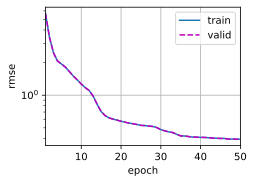

In [50]:
k, i,num_epochs, learning_rate, weight_decay, batch_size = 20, 2, 50, 0.003, 0.001, 400


data = get_k_fold_data(k, i, train_features, train_labels)
net = get_net()

train_ls, valid_ls = train_GPU(net, *data, num_epochs, learning_rate, weight_decay, batch_size)


d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
        xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
        legend=['train', 'valid'], yscale='log')

print(f'训练log rmse {float(train_ls[-1]):f}, '
              f'验证log rmse {float(valid_ls[-1]):f} ')




In [45]:
Verify_ls  = []
train_iter=d2l.load_array((train_features,train_labels),batch_size)

for X, y in train_iter:
      X = X.to(curr_device)
      y = y.to(curr_device)
      Verify_ls.append(log_rmse(net, X, y))    
      del X, y

print("RMSE is", Verify_ls )



RMSE is [0.28713035583496094, 0.30208414793014526, 0.35818594694137573, 0.28335970640182495, 0.3152148425579071, 0.33245816826820374, 0.29652678966522217, 0.36387285590171814, 0.31103721261024475, 0.3186296820640564, 0.36284568905830383, 0.31401199102401733, 0.2835228145122528, 0.37123483419418335, 0.31439512968063354, 0.28876805305480957, 0.369584321975708, 0.3009151220321655, 0.31607958674430847, 0.31755417585372925, 0.2688145935535431, 0.28738635778427124, 0.2987479269504547, 0.32510069012641907, 0.2904817759990692, 0.311657190322876, 0.33605867624282837, 0.3490166962146759, 0.2886449098587036, 0.3094867765903473, 0.29915183782577515, 0.3444842994213104, 0.3236957788467407, 0.2971752882003784, 0.2721070647239685, 0.346378356218338, 0.2959892749786377, 0.29896244406700134, 0.3269534111022949, 0.3452911972999573, 0.35070374608039856, 0.2997710406780243, 0.3085041046142578, 0.3254215121269226, 0.31539902091026306, 0.303552508354187, 0.3285697102546692, 0.28628045320510864, 0.2800472378

k, num_epochs, lr, weight_decay, batch_size = 10, 50, 0.005, 0.001, 500

train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,  weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, 'f'平均验证log rmse: {float(valid_l):f}')


In [46]:
train_data[['Bedrooms','Parking']].loc[10:15]

,Bedrooms,Parking
10,4,"Garage, Garage - Attached, Covered"
11,3,"Garage, Garage - Attached, Covered"
12,6,"Attached, Garage Door Opener, Interior Access,..."
13,3,Driveway
14,2,"Garage - Attached, Garage - Detached"
15,2,"Side By Side, Side by Side, On Site - Mapped (..."


In [47]:
train_data["Zip"]

0        94022
1        90047
2        95375
3        90230
4        93432
         ...  
47434    92225
47435    94089
47436    90046
47437    95757
47438    90720
Name: Zip, Length: 47439, dtype: int64

In [48]:


X_train, y_train, X_valid, y_valid  = get_k_fold_data(5, 1, train_features, train_labels)


train(net, X_train, y_train, X_valid, y_valid, num_epochs, lr, weight_decay, batch_size)

NameError: name 'lr' is not defined

In [ ]:
X_train, y_train, X_valid, y_valid  = get_k_fold_data(5, 1, train_features, train_labels)



net = get_net()
net[0].weight.data.device

optimizer =  torch.optim.Adam(net.parameters(), 
                                lr =  lr,
                                weight_decay= weight_decay)
for i in range(100):
    optimizer.zero_grad()
    Y = net(train_features)
    l = loss(net(train_features),train_labels)
    l.backward()
    optimizer.step()
Y

tensor([[2612.5962],
        [-525.6282],
        [-942.9823],
        ...,
        [2413.1887],
        [1449.1375],
        [2766.5569]], grad_fn=<AddmmBackward0>)

def train_and_pred(train_features, test_features, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'训练log rmse：{float(train_ls[-1]):f}')
    # 将网络应用于测试集。
    preds = net(test_features).detach().numpy()
    # 将其重新格式化以导出到Kaggle
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('.\data\submission20230515.csv', index=False)

train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)